# Chap3 端到端的模型整合

In [2]:
!python -m pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 45.5 MB 2.0 MB/s 


大多数 MLC 过程可以看作是张量函数之间的转换。我们打算在上一节课中回答的主要问题是：

* 什么是可能的张量函数抽象表达形式？
* 什么是可能的张量函数变换？
在上一课中，我们主要关注点是元张量函数。在本讲中，将讨论如何构建端到端模型。

我们引入一个**小模型**来看看模型的本质

In [3]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

代码展示功能性函数

In [4]:
import IPython

def code2html(code):
  """高亮代码"""
  import pygments
  from pygments.lexers import Python3Lexer
  from pygments.formatters import HtmlFormatter
  formatter = HtmlFormatter()
  html = pygments.highlight(code, Python3Lexer(), formatter)
  return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)


# IPython.display.HTML(code2html(MyModule.script()))

## 加载FashionMNIST数据集

In [5]:
from synr import transformer
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



打印这张图片出来：

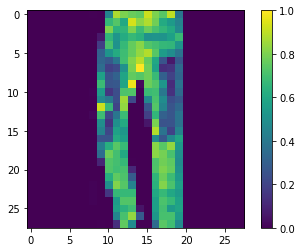

class: Trouser


In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("class:", class_names[label[0]])

## 下载模型的参数
预测图片的类别出来

In [7]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-09-22 12:33:47--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-09-22 12:33:47--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.02s   

2022-09-22 12:33:48 (18.2 MB/s) - ‘fasionmnist_mlp_params.p

## 端到端的模型整合

将使用以下模型作为示例。这是一个两层神经网络，由两个全连接层和一个有 relu 激活层组成。为了简化问题，我们删除了最终的 softmax 层。输出分数是未标准化的，但最大值仍然对应于最可能的类别。


![image-20220919212225680](https://raw.githubusercontent.com/Gary-code/pic/main/img/image-20220919212225680.png)

## Numpy模型实现
`Numpy`实现模型：

In [8]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [9]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[ -5.5949764  20.395315  -15.458015   -5.5548463  -8.960234  -27.807796
  -34.84727   -16.272167  -19.146994  -26.887331 ]]
[1]
NumPy-MLP Prediction: Trouser


上面的示例代码显示了利用高层`NumPy`数组操作，执行端到端模型执行的过程。

回到 MLC 的视角中，我们希望了解这些数组**计算的细节**。

为了说明底层细节，我们将再次用底层 `NumPy` 编写示例：

* 将在**只使用循环**而不是数组函数来演示循环计算。
* 总是通过`np.empty`**显式**分配数组并传递它们。（不包含数组初始化）

下面的代码展示了同一模型的**底层** `NumPy` 实现：

In [10]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Trouser


## 在TVMScript中构建端到端IRModule

> 有了底级`NumPy`代码作为参考，现在我们准备利用MLC**抽象来实现端到端模型运行**。下面的代码展示了模型的`TVMScript`实现。



In [11]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

上面的代码包含各种函数：我们在上一小节中看到的元张量函数（`T.prim_func`）和一个新的`R.function`（Relax 函数）。 
* Relax 函数是一种表示**上层神经网络**执行的全新**抽象**。

同样，对比查看`TVMScript`代码和底级 NumPy 代码会对我们理解代码有很大帮助。

由于我们已经了解了元张量函数，因此我们将专注于**高层的执行部分**。

![image-20220922203803449](https://raw.githubusercontent.com/Gary-code/pic/main/img/image-20220922203803449.png)

### 计算图 Computational Graph View
> * 有向无环图
> * 只希望读节点的输入，不希望写输入
> 机器学习编译的**四大抽象之一**


![image-20220922204752051](https://raw.githubusercontent.com/Gary-code/pic/main/img/image-20220922204752051.png)


使用图 (graph) 来可视化高层模型执行通常很有帮助。 上图是 main 函数的计算图视图：

* 图中的每个框都对应于计算操作。
* 箭头对应于中间张量的输入输出。
* 图本身可以看作是一种抽象，在机器学习框架中通常称为计算图 (computational graph)。

### `call_tir`
计算图中的每个操作步骤都包含一个R.call_tir操作。 这是引入元张量函数的过程：

`lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")`


为了解释 R.call_tir 的含义，让我们回顾一下操作的等效底层`NumPy`实现，如下所示：

In [13]:
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

具体来说，`call_tir`接受一个元函数`(prim_func)`的输入列表，并分配一个输出张量res，然后将输入和输出传递给`prim_func`。 执行`prim_func`后，结果会填充到`res`中，然后我们可以返回结果。

== 一个很自然的问题：**为什么**我们需要 call_tir？== 这是因为我们的元张量函数采用以下调用约定：
```python
def low_level_prim_func(in0, in1, ..., out):
    # implementations
```


此约定称为目标传递 (destination passing)。 

这个想法是输入和输出在外部显式分配并传递给底层元函数。  这种风格通常用于底层库设计，因此高层框架可以处理内存分配决策。 请注意，并非所有张量操作都可以通过这种方式呈现（比如，有些操作的输出形状取决于输入）。 然而，在通常的实践中，如果可能的话，以这种风格编写底层函数通常是有帮助的。


**虽然可以通过显式分配中间结果并调用每个函数来将目标传递的函数组装在一起，但很难将以下代码转换为计算图形式。**
* 计算图希望的是传入输入，得到输出，不想把输出一开始也构造好


下面展示一个硬转的例子：（`tensorflow 1.0`时候就是这样子的，很容易出`bug`）
* 输入不希望写出来，只希望读


In [14]:
def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

![](https://mlc.ai/zh/_images/e2e_computational_graph_numpy.png)

所以回到`call_tir`，这里的关键思想是我们想要隐藏可能的分配或对函数的显式写入。

`call_tir`使我们能够隐藏调用低层元函数细节，并将它们应用到计算图中。

已经定义了`lnumpy_call_tir`，我们可以将底层`NumPy`代码重写为, 下面这个形式就和Relax函数的形式一模一样了了：

In [15]:
def lnumpy_mlp_with_call_tir(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_tir(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Trouser


实际上，最底层的实现会有显式的内存分配，所以`call_tir`主要是为了让我们在生成实际实现之前继续做一些高层的转换。

### Dataflow Block

`Relax`函数中的另一个重要元素是`R.dataflow()`范围标注：
```python
with R.dataflow():
    lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
    lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
    out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    R.output(out)
```

这又回到了我们在上一节中讨论的计算图。 回想一下，在理想情况下，每个计算图操作都应该没有side-effect。



* dataflow block是我们标记程序计算图区域的一种方式。
* 在dataflow block中，所有操作都需要side-effect free。 
* 在dataflow block之外，操作可能包含side-effect。 

```python
@R.function
def main(x: Tensor((1, 784), "float32"),
         w0: Tensor((128, 784), "float32"),
         b0: Tensor((128,), "float32"),
         w1: Tensor((10, 128), "float32"),
         b1: Tensor((10,), "float32")):

    with R.dataflow():
        lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
        gv0 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
        R.output(gv0)

    gv1 = R.alloc_tensor((1, 128), dtype="float32")

    with R.dataflow():
        out = R.call_tir(linear1, (gv0, gv1, b0), (1, 128), dtype="float32")
        R.output(out)
    return out
```

## 构建并部署模型
本节介绍如何构建和运行 IRModule。 让我们首先回顾一下我们现有的 IRModule。

In [18]:
IPython.display.Code(MyModule.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"], Y: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"], W: T.Buffer[(10, 128), "float32"], B: T.Buffer[10, "float32"], Z: T.Buffer[(1, 10), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: Tensor((1, 784), "float32"), w0: Tensor((128, 784), "float32"), b0: Tensor((128,), "float32"), w1: Tensor((10, 128), "float32"), b1: Tensor((10,), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

调用`relax.vm.build`来构建这个函数。 注意：Relax 仍在开发中，因此某些 API 可能会更改。 不过，我们的主要目标是熟悉端到端模型的整体 MLC 流程（构造、转换、构建）。

In [19]:
ex = relax.vm.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm.Executable

build 函数会给我们一个可执行文件（译者注：“可执行文件”并非传统操作系统中的可执行文件，不能直接在系统中运行，而是针对Relax VM设计的一种文件格式）。 我们可以初始化一个虚拟机执行器，使我们能够运行该函数。 此外，我们将传入第二个参数，指示我们要在哪个设备上运行端到端执行。

In [20]:
vm = relax.VirtualMachine(ex, tvm.cpu())

现在我们准备好运行模型了。 我们首先构建包含输入数据和权重的 tvm NDArray。

In [21]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

然后我们可以通过传入输入参数和权重来运行 main 函数。

In [22]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

[[ -5.5949764  20.395315  -15.4580145  -5.5548496  -8.960231  -27.807793
  -34.847267  -16.272165  -19.146992  -26.887331 ]]


main 函数返回预测结果，然后我们可以调用nd_res.numpy()将其转换为 Numpy 数组，并取 argmax 获取类标签。

In [23]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Trouser


### 在环境中集成现有运行库

展示了如何构建一个包含元张量函数实现以及计算图部分的 IRModule。 在许多情况下，我们可能希望将现有的库函数集成到 MLC 过程中。

下面的 IRModule 展示了如何做到这一点：


In [24]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

请注意，我们现在直接在 call_tir 中传入字符串：

`R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")`

这些字符串是我们期望在模型执行期间的运行时函数 (runtime function) 的名称。

 注册运行函数到环境里面:

In [27]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)  # 框架之间转tensor的，指向的是同一块内存（工业界的规范）
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

在上面的代码中，我们使用`from_dlpack`将 `TVM NDArray` 转换为 `torch NDArray`。 请注意，这是一个零拷贝转换，这意味着 Torch 阵列与 TVM NDArray 共享底层内存。 
**`DLPack`是一种通用的交换标准，允许不同的框架交换 Tensor/NDArray 而无需参与数据复制。 from_dlpack API 由多个框架支持，是 Python 数组 API 标准的一部分。 **

在这个特定的函数中，我们只是简单地调用 PyTorch 的实现。 在真实的应用场景中，我们可以使用类似的机制将调用重定向到特定的库，例如 cuDNN 或我们自己的库实现。

这个特定示例在`Python`中执行注册。 实际上，我们可以用不同的语言（例如 C++）注册没有`Python` 依赖的函数。

编译和执行：

现在我们可以构建并运行MyModuleWithExternCall，我们可以验证模型得到了相同的结果。

In [28]:
ex = relax.vm.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Trouser


### Mixing TensorIR Code and Libraries

在上一个示例中，我们构建了一个`IRModule`，其中所有元操作都被分派给运行库。有时将两者混合使用会有所帮助。(TVM tensorIR 和 环境的都可以)


In [29]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

上面的代码块显示了一个示例，其中 linear0 仍然在 TensorIR 中实现，而其余函数被重定向到库函数。 我们可以构建并运行以验证结果。

In [30]:
ex = relax.vm.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Trouser


### 将参数绑定到 IRModule

在到目前为止的所有示例中，我们通过显式传递参数来构造主函数。 在许多情况下，将参数绑定为附加到 IRModule 的常量通常会降低API的复杂程度（**模型有很多层的时候，参数列表太大**）。 

以下代码通过将**参数名称**与`nd_params`中的键匹配来创建绑定。



In [31]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
IPython.display.Code(MyModuleWithParams.script(), language="python")

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, meta[relay.Constant][0], meta[relay.Constant][1]), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, meta[relay.Constant][2], meta[relay.Constant][3]), (1, 10), dtype="float32")
            R.output(out)
        return out
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

在上面的脚本中，meta[relay.Constant][0] 对应于一个存储常量的隐式字典（它没有显示为脚本的一部分，但仍然是 IRModule 的一部分）。 如果我们构建转换后的 IRModule，我们现在可以通过传入输入数据来调用该函数。

**编译的时候就只有一个参数了**

In [32]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Trouser
